# Bike Approach Sandbox

This notebook documents development of a pipeline for reading bicycle approach-based counts and uploading results to Postgres.

In [1]:
import psycopg2
import math
import pytz
import datetime
import dateutil
import requests
import json
import pandas as pd
import pathlib
import configparser
import matplotlib.pyplot as plt

import sys
import intersection_tmc_notebook06test as itmc

In [2]:
# Grab Postgres and Miovision credentials.
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix())
postgres_settings = config['POSTGRES']
miov_token = config['MIOVISION']['key']

In [3]:
start_time = dateutil.parser.parse('2021-05-04 12:00:00')
end_time = dateutil.parser.parse('2021-05-04 15:00:00')

## Get Intersection IDs

In [4]:
# Retrieve data from the Postgres raw data.
sql_query = """SELECT *
FROM miovision_api.intersections
"""

with psycopg2.connect(**postgres_settings) as db_con:
    df_int = pd.read_sql(sql_query, db_con)
    
intersection_id_lookup = dict(zip(df_int['intersection_name'], df_int['id']))
intersection_uid_lookup = dict(zip(df_int['intersection_name'], df_int['intersection_uid']))

## Examine API Response For Bike Approach Volumes

In [5]:
def get_intersection_tmc_raw(start_time, end_time, intersection_id1,
                             intersection_uid, key=miov_token):

    headers={'Content-Type': 'application/json',
             'Authorization':key}

    # Subtract 1 ms from endTime to handle hallucinated rows that occur at
    # exactly endTime (See bdit_data-sources/#374).
    params = {'endTime': (end_time
                          - datetime.timedelta(milliseconds=1)),
              'startTime': start_time}

    response = itmc.session.get(
        itmc.url + intersection_id1 + itmc.tmc_endpoint,
        params=params, headers=headers, proxies=itmc.session.proxies)
    
    return response

response = get_intersection_tmc_raw(start_time, end_time, intersection_id_lookup['Richmond / Bay'],
                                    intersection_uid_lookup['Richmond / Bay'])

In [6]:
tmc_data = json.loads(response.content.decode('utf-8'))
df_tmc_data = pd.DataFrame(tmc_data)

In [7]:
df_tmc_data.loc[df_tmc_data['class'] == 'Bicycle', :]

,timestamp,class,entrance,exit,qty
9,2021-05-04T12:01:00.000-04:00,Bicycle,E,UNDEFINED,1
10,2021-05-04T12:01:00.000-04:00,Bicycle,E,W,1
26,2021-05-04T12:04:00.000-04:00,Bicycle,E,UNDEFINED,2
27,2021-05-04T12:04:00.000-04:00,Bicycle,E,W,1
36,2021-05-04T12:06:00.000-04:00,Bicycle,N,S,1
...,...,...,...,...,...
1115,2021-05-04T14:57:00.000-04:00,Bicycle,E,UNDEFINED,1
1116,2021-05-04T14:57:00.000-04:00,Bicycle,E,W,1
1125,2021-05-04T14:59:00.000-04:00,Bicycle,E,UNDEFINED,1
1126,2021-05-04T14:59:00.000-04:00,Bicycle,S,N,1


In [8]:
df_tmc_data.loc[(df_tmc_data['class'] == 'Bicycle')
                & (df_tmc_data['entrance'] == 'UNDEFINED'), :].head()

,timestamp,class,entrance,exit,qty
38,2021-05-04T12:06:00.000-04:00,Bicycle,UNDEFINED,N,1
39,2021-05-04T12:06:00.000-04:00,Bicycle,UNDEFINED,S,1
52,2021-05-04T12:08:00.000-04:00,Bicycle,UNDEFINED,N,3
59,2021-05-04T12:09:00.000-04:00,Bicycle,UNDEFINED,S,1
78,2021-05-04T12:15:00.000-04:00,Bicycle,UNDEFINED,N,1


In [9]:
tmc_data[9]

{'timestamp': '2021-05-04T12:01:00.000-04:00',
 'class': 'Bicycle',
 'entrance': 'E',
 'exit': 'UNDEFINED',
 'qty': 1}

In [10]:
tmc_data[38]

{'timestamp': '2021-05-04T12:06:00.000-04:00',
 'class': 'Bicycle',
 'entrance': 'UNDEFINED',
 'exit': 'N',
 'qty': 1}

Miovision returns bike approach volumes as:

```
{'timestamp': '2021-05-04T12:01:00.000-04:00',
 'class': 'Bicycle',
 'entrance': 'E',
 'exit': 'UNDEFINED',
 'qty': 1}
```

and departure volumes as:

```
{'timestamp': '2021-05-04T12:06:00.000-04:00',
 'class': 'Bicycle',
 'entrance': 'UNDEFINED',
 'exit': 'N',
 'qty': 1}
```

Currently in the API, the `leg` is defined solely by `item['entrance']`, so we at least need to generalize extracting leg and movement so that `item['exit']` is used if `item['entrance']` is undefined. This suggests to me a more general function that returns both leg and movement.

## New Miovision API Puller Class

In [33]:
from collections import namedtuple
import datetime
import sys

# Entrance-exit pairs.
EEPair = namedtuple('EEPair', ['entrance', 'exit'])

class MiovPuller:
    """Miovision API puller.
    
    Basic workflow is to initialize the class, then use `get_intersection` to
    pull TMC and crosswalk data for an intersection over one period of time.
    
    Parameters
    ----------
    int_id1 : str
        Intersection hex-ID (`id` in `miovision_api.intersections`).
    int_uid : str
        Intersection UID (`intersection_uid` in `miovision_api.intersections`)
    key : str
        Miovision API access key.
    """
    
    headers = {'Content-Type': 'application/json',
              'Authorization': ''}
    
    tmc_template = itmc.url + "{int_id1}" + itmc.tmc_endpoint
    ped_template = itmc.url + "{int_id1}" + itmc.ped_endpoint
    
    roaduser_class = {
        'Light': '1',
        'BicycleTMC': '2',
        'Bus': '3',
        'SingleUnitTruck': '4',
        'ArticulatedTruck': '5',
        'WorkVan': '8',
        'MotorizedVehicle': '9',
        'Bicycle': '10'
    }

    # Lookup table for all TMC movements that are not u-turns.
    tmc_movements_no_uturn = {
        EEPair(entrance='N', exit='S'): '1',
        EEPair(entrance='S', exit='N'): '1',
        EEPair(entrance='W', exit='E'): '1',
        EEPair(entrance='E', exit='W'): '1',
        EEPair(entrance='S', exit='W'): '2',
        EEPair(entrance='N', exit='E'): '2',
        EEPair(entrance='W', exit='N'): '2',
        EEPair(entrance='E', exit='S'): '2',
        EEPair(entrance='S', exit='E'): '3',
        EEPair(entrance='E', exit='N'): '3',
        EEPair(entrance='N', exit='W'): '3',
        EEPair(entrance='W', exit='S'): '3',    
    }
    
    crosswalkuser_class = {
        'Pedestrian': '6',
        'Bicycle': '7'
    }

    crosswalk_mvmts = {
        'CW': '5',
        'CCW': '6'
    }

    def __init__(self, int_id1, int_uid, key):
        self.headers['Authorization'] = key
        self.int_id1 = int_id1
        self.intersection_uid = int_uid

    def get_response(self, apitype, start_time, end_iteration_time):
        """Requests data from API."""

        params = {'endTime': (end_iteration_time
                              - datetime.timedelta(milliseconds=1)),
                  'startTime': start_time}

        # Select the appropriate request URL depending on which API we're
        # pulling from.
        if apitype == 'crosswalk':
            request_url = self.ped_template.format(int_id1=self.int_id1)
        elif apitype == 'tmc':
            request_url = self.tmc_template.format(int_id1=self.int_id1)    
        else:
            raise ValueError("apitype must be either 'tmc' or 'crosswalk'!")

        response = itmc.session.get(
            request_url, params=params, headers=self.headers,
            proxies=itmc.session.proxies)

        # Return if we get a success response code, or raise an error if not.
        if response.status_code == 200:
            return response
        elif response.status_code == 404:
            error = json.loads(response.content.decode('utf-8'))
            itmc.logger.error("Problem with ped call for intersection %s",
                               self.int_id1)
            itmc.logger.error(error['error'])
            raise NotFoundError
        elif response.status_code == 400:
            itmc.logger.critical(("Bad request error when pulling ped data for "
                                   "intersection {0} from {1} until {2}")
                                  .format(self.int_id1, start_time,
                                          end_iteration_time))
            error = json.loads(response.content.decode('utf-8'))
            itmc.logger.critical(error['error'])
            sys.exit(5)
        elif response.status_code == 504:
            raise itmc.TimeoutException('Error' + str(response.status_code))
        elif response.status_code == 500:
            raise itmc.ServerException('Error' + str(response.status_code))

        # If code isn't handled in the block above, throw a general error.
        itmc.logger.critical('Unknown error pulling ped data for intersection %s',
                             self.int_id1)
        raise itmc.MiovisionAPIException('Error' + str(response.status_code))

    def get_road_class(self, row):
        """Get road user class."""

        is_approach = ((row['entrance'] == 'UNDEFINED')
                       or (row['exit'] == 'UNDEFINED'))
        # Second check isn't strictly necessary but better safe than sorry.
        if not is_approach and (row['class'] == 'Bicycle'):
            ru_class = 'BicycleTMC'
        else:
            ru_class = row['class']

        try:
            return self.roaduser_class[ru_class]
        except KeyError:
            raise ValueError("vehicle class {0} not recognized!"
                             .format(row['class']))

    def get_road_leg_and_movement(self, row):
        """Get intersection leg and movement UID.

        Due to bike approach counts, these two data are
        coupled.
        """
        # Classes 7 and 8 are for bike approach volumes.
        if row['exit'] == 'UNDEFINED':
            return (row['entrance'], '7')
        elif row['entrance'] == 'UNDEFINED':
            return (row['exit'], '8')
        elif row['entrance'] == row['exit']:
            return (row['entrance'], '4')
        movement = self.tmc_movements_no_uturn[
            EEPair(entrance=row['entrance'], exit=row['exit'])]
        return (row['entrance'], movement)

    def get_crosswalk_class(self, row):
        """Get crosswalk road user class."""
        try:
            return self.crosswalkuser_class[row['class']]
        except KeyError:
            raise ValueError("crosswalk class {0} not recognized!"
                             .format(row['class']))

    def get_crosswalk_movement(self, row):
        """Get crosswalk movement."""
        try:
            return self.crosswalk_mvmts[row['direction']]
        except KeyError:
            raise ValueError("crosswalk movement {0} not recognized!"
                             .format(row['direction']))

    def process_tmc_row(self, row):
        """Process one row of TMC API output."""

        classification = self.get_road_class(row)
        (leg, movement) = self.get_road_leg_and_movement(row)

        # Return time, classification_uid, leg, movement, volume.
        return (row['timestamp'], classification, leg, movement, row['qty'])
    
    def process_crosswalk_row(self, row):
        """Process one row of crosswalk API output."""
        classification = self.get_crosswalk_class(row)
        movement = self.get_crosswalk_movement(row)

        # Return time, classification_uid, leg, movement, volume.
        return (row['timestamp'], classification, row['crosswalkSide'], movement, row['qty'])

    def process_response(self, apitype, response):
        """Process the output of self.get_response."""
        data = json.loads(response.content.decode('utf-8'))
        if apitype == 'crosswalk':
            return [(self.intersection_uid, ) + self.process_crosswalk_row(row) for row in data]
        return [(self.intersection_uid, ) + self.process_tmc_row(row) for row in data]

    def get_intersection(self, start_time, end_iteration_time):
        """Get all data for one intersection between start and end time."""
        response_tmc = self.get_response('tmc', start_time, end_iteration_time)
        table_veh = self.process_response('tmc', response_tmc)
        response_crosswalk = self.get_response('crosswalk', start_time, end_iteration_time)
        table_ped = self.process_response('crosswalk', response_crosswalk)

        return table_veh, table_ped

In [12]:
miovpull = MiovPuller(intersection_id_lookup['Richmond / Bay'],
                      intersection_uid_lookup['Richmond / Bay'], miov_token)

In [13]:
%%time
_, _ = miovpull.get_intersection(start_time, end_time)

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 1.79 s


In [14]:
def pull_using_old_interface(start_time, end_time, intersection_id,
                             intersection_uid, miov_token):
    veh = itmc.get_intersection_tmc(start_time, end_time, intersection_id,
                                    intersection_uid, miov_token)
    ped = itmc.get_crosswalk_tmc(start_time, end_time, intersection_id,
                                 intersection_uid, miov_token)
    return veh, ped

In [15]:
%%time
_, _ = pull_using_old_interface(start_time, end_time, intersection_id_lookup['Richmond / Bay'],
                                intersection_uid_lookup['Richmond / Bay'], miov_token)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 1.67 s


I've tried this timing test a few times, and get 1.5 - 3 seconds for both, so whatever code performance difference that exists between the old and new code is being completely drowned out by the API response time.

### Smoke Testing
This is a pretty big refactoring, so we need to test that the outputs are the same (except for the introduction of class 10). Let's do this for a random sampling of dates, times and locations.

In [16]:
def check_miovpull(start_time, end_time, intersection_id, intersection_uid, miov_token):

    miovpull = MiovPuller(intersection_id, intersection_uid, miov_token)
    df_v, df_c = miovpull.get_intersection(start_time, end_time)
    df = pd.DataFrame(df_v + df_c,
                      columns=('intersection_uid', 'timestamp',
                               'classification_uid', 'leg', 'movement_uid', 'volume'))
    df_nobikeapproach = df.loc[df['classification_uid'] != '10', :].reset_index(drop=True)

    df_r_v, df_r_c = pull_using_old_interface(
        start_time, end_time, intersection_id, intersection_uid, miov_token)
    df_ref = pd.DataFrame(
        df_r_v + df_r_c,
        columns=('intersection_uid', 'timestamp',
                 'classification_uid', 'leg', 'movement_uid', 'volume'))
    
    assert df_ref.equals(df_nobikeapproach), "reference and candidate data frames don't match!"
    
    return df

In [17]:
df = check_miovpull(dateutil.parser.parse('2021-05-04 12:00:00'),
                    dateutil.parser.parse('2021-05-04 15:00:00'),
                    intersection_id_lookup['Richmond / Bay'],
                    intersection_uid_lookup['Richmond / Bay'],
                    miov_token)

In [18]:
df = check_miovpull(dateutil.parser.parse('2021-04-01 12:00:00'),
                    dateutil.parser.parse('2021-04-02 15:00:00'),
                    intersection_id_lookup['Bloor / Avenue'],
                    intersection_uid_lookup['Bloor / Avenue'],
                    miov_token)

In [19]:
df = check_miovpull(dateutil.parser.parse('2021-02-20 09:00:00'),
                    dateutil.parser.parse('2021-02-20 11:00:00'),
                    intersection_id_lookup['Dundas / River'],
                    intersection_uid_lookup['Dundas / River'],
                    miov_token)

In [20]:
df = check_miovpull(dateutil.parser.parse('2021-01-30 19:00:00'),
                    dateutil.parser.parse('2021-01-30 23:00:00'),
                    intersection_id_lookup['Queen / Spadina'],
                    intersection_uid_lookup['Queen / Spadina'],
                    miov_token)

In [21]:
df = check_miovpull(dateutil.parser.parse('2021-03-11 16:00:00'),
                    dateutil.parser.parse('2021-03-11 18:00:00'),
                    intersection_id_lookup['Sheppard / Wilmington'],
                    intersection_uid_lookup['Sheppard / Wilmington'],
                    miov_token)

## Inspecting Bike Approach Volumes

In [22]:
start_time = dateutil.parser.parse('2021-05-14 00:00:00')
end_time = dateutil.parser.parse('2021-05-15 00:00:00')
int_id1 = intersection_id_lookup['Adelaide / Jarvis']
int_uid = intersection_id_lookup['Adelaide / Jarvis']

miovpull = MiovPuller(int_id1, int_uid, miov_token)
df_v, df_c = miovpull.get_intersection(start_time, end_time)
df = pd.DataFrame(df_v + df_c,
                  columns=('intersection_uid', 'timestamp',
                           'classification_uid', 'leg', 'movement_uid', 'volume'))

In [23]:
df.loc[df['classification_uid'] == '10', :]

,intersection_uid,timestamp,classification_uid,leg,movement_uid,volume


That's not good. As of today, which locations have class 10 data?

In [41]:
start_time = dateutil.parser.parse('2021-05-25 16:00:00')
end_time = dateutil.parser.parse('2021-05-25 19:00:00')

for key in intersection_id_lookup.keys():
    miovpull = MiovPuller(intersection_id_lookup[key],
                          intersection_uid_lookup[key],
                          miov_token)
    df_v, df_c = miovpull.get_intersection(start_time, end_time)
    cdf = pd.DataFrame(df_v + df_c,
                       columns=('intersection_uid', 'timestamp',
                                'classification_uid', 'leg', 'movement_uid', 'volume'))
    
    print("Intersection {0} ({1}) has {2} class 2 and {3} class 10 counts"
          .format(intersection_uid_lookup[key], key,
                  cdf.loc[cdf['classification_uid'] == '2', 'volume'].sum(),
                  cdf.loc[cdf['classification_uid'] == '10', 'volume'].sum()))

Intersection 1 (Adelaide / Bathurst) has 276 class 2 and 0 class 10 counts
Intersection 2 (Adelaide / Spadina) has 265 class 2 and 761 class 10 counts
Intersection 3 (Adelaide / Bay) has 388 class 2 and 433 class 10 counts
Intersection 4 (Adelaide / Jarvis) has 394 class 2 and 0 class 10 counts
Intersection 5 (Front / Bathurst) has 333 class 2 and 0 class 10 counts
Intersection 6 (Front / Spadina) has 316 class 2 and 75 class 10 counts
Intersection 7 (Front / Bay) has 405 class 2 and 210 class 10 counts
Intersection 8 (Front / Jarvis) has 317 class 2 and 275 class 10 counts
Intersection 9 (King / Strachan) has 0 class 2 and 0 class 10 counts
Intersection 10 (King / Bathurst) has 825 class 2 and 278 class 10 counts
Intersection 11 (King / Portland) has 0 class 2 and 0 class 10 counts
Intersection 12 (King / Spadina) has 905 class 2 and 356 class 10 counts
Intersection 13 (King / Peter) has 0 class 2 and 0 class 10 counts
Intersection 14 (King / Simcoe) has 0 class 2 and 0 class 10 count

So intersections 1, 4, 5 and 43 may not yet have been setup for approach counts. We'll ask Miovision about that.

Another issue - why are all the approach volumes lower than the TMCs? Is this consistent behaviour?

In [25]:
def plot_volumes(start_time, end_time, int_id1, int_uid):

    miovpull = MiovPuller(int_id1, int_uid, miov_token)
    df_v, df_c = miovpull.get_intersection(start_time, end_time)
    df = pd.DataFrame(df_v + df_c,
                      columns=('intersection_uid', 'timestamp',
                               'classification_uid', 'leg', 'movement_uid', 'volume'))

    df_biketmcs = df.loc[df['classification_uid'] == '2', ['timestamp', 'volume']].copy()
    df_biketmcs['timestamp'] = pd.to_datetime(
        df_biketmcs['timestamp']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))

    df_bikeapproach = df.loc[df['classification_uid'] == '10', ['timestamp', 'volume']].copy()
    df_bikeapproach['timestamp'] = pd.to_datetime(
        df_bikeapproach['timestamp']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))
    
    fig, ax = plt.subplots(figsize=(14, 7))

    (df_biketmcs.groupby('timestamp')['volume'].sum()).plot(ax=ax, label='TMC Volume')
    (df_bikeapproach.groupby('timestamp')['volume'].sum() / 2.).plot(ax=ax, label='Approach Volume')

    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Volume', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    ax.legend(loc=2, fontsize=14)
    ax.set_title('Intersection UID {0} - TMC vol {1} - ATR vol {2}'
                 .format(int_uid, df_biketmcs['volume'].sum(), df_bikeapproach['volume'].sum() / 2.));

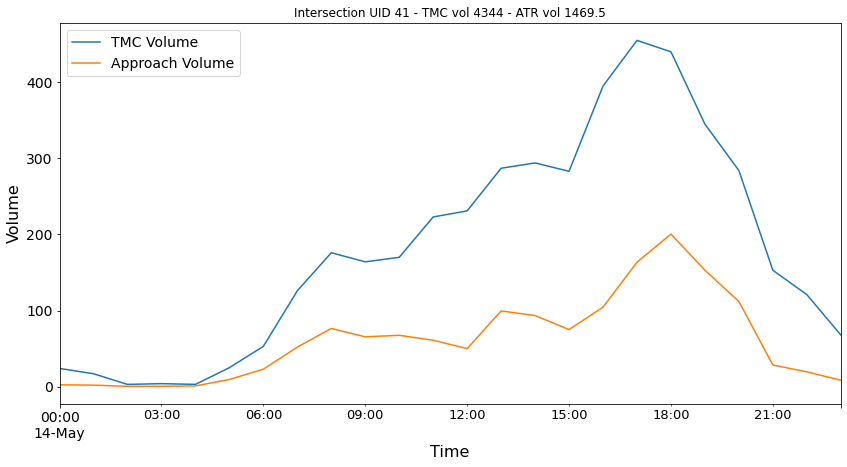

In [26]:
plot_volumes(dateutil.parser.parse('2021-05-14 00:00:00'),
             dateutil.parser.parse('2021-05-15 00:00:00'),
             intersection_id_lookup['Bloor / Bay'],
             intersection_uid_lookup['Bloor / Bay'])

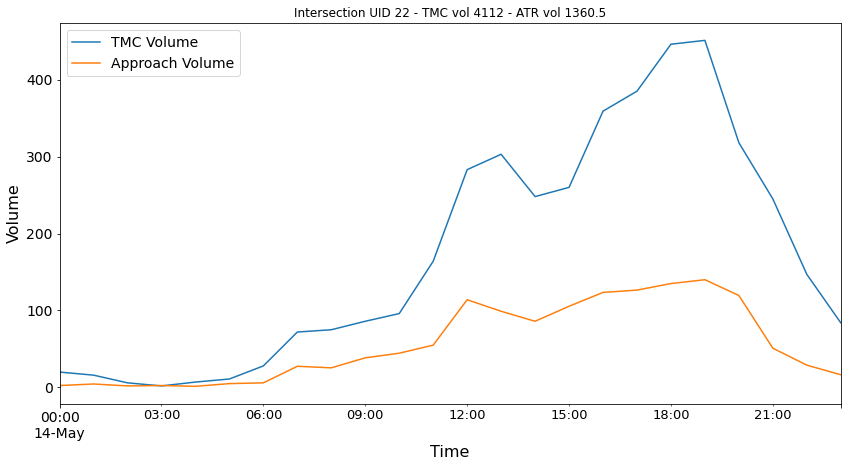

In [27]:
plot_volumes(dateutil.parser.parse('2021-05-14 00:00:00'),
             dateutil.parser.parse('2021-05-15 00:00:00'),
             intersection_id_lookup['Queen / Bathurst'],
             intersection_uid_lookup['Queen / Bathurst'])

(Here we account for bike approach/departure being double counted by dividing the sum by two.)

Is this accurate? Did we accidentally flip TMC and approach volumes? This seems unrealistic since our smoke testing earlier showed no difference between API pulls from the old and new code so long as class 10 wasn't included. To double-check, we can directly pull from the API for Bloor / Bay.

In [28]:
params = {'endTime': (dateutil.parser.parse('2021-05-15 00:00:00')
                      - datetime.timedelta(milliseconds=1)),
          'startTime': dateutil.parser.parse('2021-05-14 00:00:00')}
response = itmc.session.get("https://api.miovision.com/intersections/0e574ac8-bb57-46f0-b2a1-49bd48e1a503/tmc",
                            params=params, headers=miovpull.headers, proxies=itmc.session.proxies)
df_ref = pd.DataFrame(json.loads(response.content.decode('utf-8')))

In [29]:
df_ref.loc[(df_ref['class'] == 'Bicycle')
           & ((df_ref['entrance'] == 'UNDEFINED') | (df_ref['exit'] == 'UNDEFINED')), 'qty'].sum() / 2.

1469.5

In [30]:
df_ref.loc[(df_ref['class'] == 'Bicycle')
           & ((df_ref['entrance'] != 'UNDEFINED') & (df_ref['exit'] != 'UNDEFINED')), 'qty'].sum()

4344

which are exactly the same numbers obtained by the new API puller. Something fishy is going on. Let's generate a set of all-day totals to speak with Brent about.

In [42]:
start_time = dateutil.parser.parse('2021-05-25 00:00:00')
end_time = dateutil.parser.parse('2021-05-26 00:00:00')

for key in intersection_id_lookup.keys():
    miovpull = MiovPuller(intersection_id_lookup[key],
                          intersection_uid_lookup[key],
                          miov_token)
    df_v, df_c = miovpull.get_intersection(start_time, end_time)
    cdf = pd.DataFrame(df_v + df_c,
                       columns=('intersection_uid', 'timestamp',
                                'classification_uid', 'leg', 'movement_uid', 'volume'))
    
    print("Intersection {0} ({1}) has {2} class 2 and {3} class 10 counts"
          .format(intersection_uid_lookup[key], key,
                  cdf.loc[cdf['classification_uid'] == '2', 'volume'].sum(),
                  cdf.loc[cdf['classification_uid'] == '10', 'volume'].sum()))

Intersection 1 (Adelaide / Bathurst) has 1006 class 2 and 0 class 10 counts
Intersection 2 (Adelaide / Spadina) has 1070 class 2 and 2979 class 10 counts
Intersection 3 (Adelaide / Bay) has 1265 class 2 and 1451 class 10 counts
Intersection 4 (Adelaide / Jarvis) has 1216 class 2 and 0 class 10 counts
Intersection 5 (Front / Bathurst) has 1125 class 2 and 0 class 10 counts
Intersection 6 (Front / Spadina) has 1214 class 2 and 386 class 10 counts
Intersection 7 (Front / Bay) has 1430 class 2 and 729 class 10 counts
Intersection 8 (Front / Jarvis) has 1163 class 2 and 924 class 10 counts
Intersection 9 (King / Strachan) has 0 class 2 and 0 class 10 counts
Intersection 10 (King / Bathurst) has 2924 class 2 and 1158 class 10 counts
Intersection 11 (King / Portland) has 0 class 2 and 0 class 10 counts
Intersection 12 (King / Spadina) has 3115 class 2 and 1142 class 10 counts
Intersection 13 (King / Peter) has 0 class 2 and 0 class 10 counts
Intersection 14 (King / Simcoe) has 0 class 2 and 0